In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from PIL import Image
from typing import Sequence
from matplotlib.figure import Figure
from random import randint
from IPython.display import display

from ba_dev.dataset import MammaliaDataSequence, MammaliaDataImage
from ba_dev.transform import ImagePipeline, BatchImagePipeline
from ba_dev.utils import load_config_yaml, plot_image_with_bbox, BBox

paths = load_config_yaml('../path_config.yml')

In [2]:
# save_fig_path = paths['figures']
save_fig_path = None

cm = 1 / 2.54  # cm to inch conversion

plt.rcParams['axes.titlesize'] = 10  # Adjust the size of the title
plt.rcParams['axes.labelsize'] = 8  # Adjust the size of the axis labels
plt.rcParams['xtick.labelsize'] = 6  # Adjust the size of the x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Adjust the size of the y-axis tick labels
plt.rcParams['font.size'] = 8  # General font size for all text elements
plt.rcParams['legend.fontsize'] = 6  # Font size for legend text

# Set global line width for axes and ticks
plt.rcParams['axes.linewidth'] = 0.2  # Adjust the thickness of the axes frame lines
plt.rcParams['xtick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the x-axis
plt.rcParams['ytick.major.width'] = 0.1  # Adjust the thickness of the major tick lines on the y-axis
plt.rcParams['xtick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the x-axis
plt.rcParams['ytick.minor.width'] = 0.05  # Adjust the thickness of the minor tick lines on the y-axis

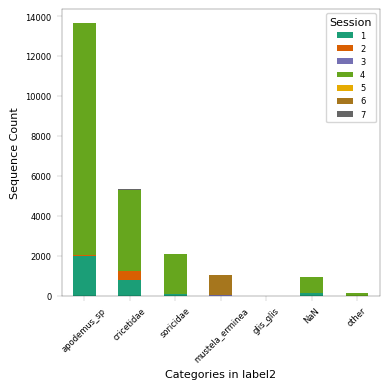

In [3]:
########################################################################################################################
# Plot available Sequences per Label
fig_name = "label2_session.pdf"
fig_size = (10*cm,10*cm)
########################################################################################################################

label_files = paths['labels'].glob('*.csv')

df = pd.DataFrame()

for file in label_files:
    df = pd.concat([df, pd.read_csv(file)], ignore_index=True)

df["label2"] = df["label2"].fillna("NaN")

counts = df.groupby(["label2", "session"]).size().unstack(fill_value=0)
counts["total"] = counts.sum(axis=1)

special_labels = ["NaN", "other"]

regular = counts[~counts.index.isin(special_labels)].sort_values("total", ascending=False)
special = counts[counts.index.isin(special_labels)]

counts_sorted = pd.concat([regular, special])
counts_sorted = counts_sorted.drop(columns="total")

# Create figure
fig, ax = plt.subplots(figsize=(fig_size[0], fig_size[1]))

counts_sorted.plot(
    kind="bar",
    stacked=True,
    ax=ax,
    colormap="Dark2"
)

ax.set_xlabel("Categories in label2")
ax.set_ylabel("Sequence Count")
ax.tick_params(axis='x', rotation=45)
ax.legend(title="Session", loc='upper right')

plt.tight_layout()

if save_fig_path is not None:
    plt.savefig(save_fig_path / fig_name, dpi=300)

plt.show()


### Image Level Evaluation

In [4]:
dataset_img = MammaliaDataImage(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:233: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


In [5]:
dataset_img[0]

{'x': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536>,
 'y': 0,
 'class_name': 'apodemus_sp',
 'bbox': [0.0888, 0.5299, 0.3642, 0.1979],
 'conf': 0.979,
 'seq_id': 3000000,
 'file_path': PosixPath('sessions/session_03/28/IMG_0016.JPG')}

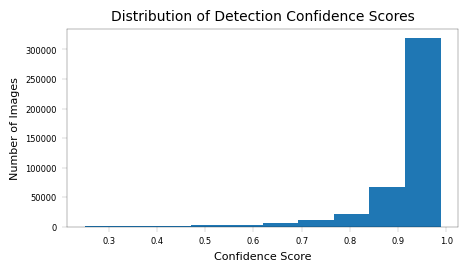

In [6]:
########################################################################################################################
# Plot Histogram of Detection Confidence Scores
fig_name = 'detection_conf_hist.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

df = dataset_img.ds

plt.figure(figsize=fig_size)
plt.hist(df['conf'], bins=10)
plt.title('Distribution of Detection Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

### Sequence Level Evaluation

In [7]:
dataset_seq = MammaliaDataSequence(
    path_labelfiles=paths['labels'],
    path_to_dataset=paths['dataset'],
    path_to_detector_output=paths['md_output'],
    detector_model=None,
    mode='eval',
    image_pipeline=None,
)

/cfs/earth/scratch/kraftjul/BA_package/ba_dev/dataset.py:233: UserWarning: With the detection confidence of 0.25,
309 sequences had no detections and will be excluded.
Excluded sequences: [6000646, 6000663, 6000665, 6000679, 6000680, 6000681, 6000683, 4001841, 1001523, 6000691] ...
  warnings.warn(


In [8]:
dataset_seq.ds

session    SerialNumber  seq_nr   seq_id                    Directory  \
0            3  H550HF07158839       1  3000000       sessions/session_03/28   
3            3  H550HF07158878       1  3000003       sessions/session_03/42   
4            3  H550HF07158878       2  3000004       sessions/session_03/42   
5            3  H550HF07158933       1  3000005        sessions/session_03/7   
6            3  H550HF07158933       2  3000006        sessions/session_03/7   
...        ...             ...     ...      ...                          ...   
23226        4  H550HF08161368     235  4018684  sessions/session_04/W7-WK06   
23227        4  H550HF08161368     236  4018685  sessions/session_04/W7-WK06   
23228        4  H550HF08161368     237  4018686  sessions/session_04/W7-WK06   
23229        4  H550HF08161368     238  4018687  sessions/session_04/W7-WK06   
23230        4  H550HF08161368     239  4018688  sessions/session_04/W7-WK06   

             DateTime_start          DateTime_end  duration_seconds  \
0      2020-03-29T20:57:38Z  2020-03-29T20:57:59Z              21.0   
3      2020-03-30T08:50:52Z  2020-03-30T08:50:54Z               2.0   
4      2020-04-16T01:20:36Z  2020-04-16T01:20:41Z               5.0   
5      2020-04-11T14:05:39Z  2020-04-11T14:06:29Z              50.0   
6      2020-04-11T14:24:35Z  2020-04-11T14:24:44Z               9.0   
...                     ...                   ...               ...   
23226  2020-07-17T23:42:26Z  2020-07-17T23:42:36Z              10.0   
23227  2020-07-17T23:45:10Z  2020-07-17T23:45:34Z              24.0   
23228  2020-07-18T01:56:54Z  2020-07-18T01:57:18Z              24.0   
23229  2020-07-18T02:06:30Z  2020-07-18T02:06:42Z              12.0   
23230  2020-07-18T07:47:46Z  2020-07-18T07:47:48Z               2.0   

         first_file     last_file  n_files  \
0      IMG_0001.JPG  IMG_0024.JPG       24   
3      IMG_0001.JPG  IMG_0003.JPG        3   
4      IMG_0004.JPG  IMG_0009.JPG        6   
5      IMG_0001.JPG  IMG_0024.JPG       24   
6      IMG_0025.JPG  IMG_0031.JPG        7   
...             ...           ...      ...   
23226  IMG_4228.JPG  IMG_4236.JPG        9   
23227  IMG_4237.JPG  IMG_4248.JPG       12   
23228  IMG_4249.JPG  IMG_4263.JPG       15   
23229  IMG_4264.JPG  IMG_4269.JPG        6   
23230  IMG_4270.JPG  IMG_4272.JPG        3   

                                               all_files             label  \
0      IMG_0001.JPG,IMG_0002.JPG,IMG_0003.JPG,IMG_000...       apodemus_sp   
3                 IMG_0001.JPG,IMG_0002.JPG,IMG_0003.JPG   mustela_erminea   
4      IMG_0004.JPG,IMG_0005.JPG,IMG_0006.JPG,IMG_000...       apodemus_sp   
5      IMG_0001.JPG,IMG_0002.JPG,IMG_0003.JPG,IMG_000...       apodemus_sp   
6      IMG_0025.JPG,IMG_0026.JPG,IMG_0027.JPG,IMG_002...       apodemus_sp   
...                                                  ...               ...   
23226  IMG_4228.JPG,IMG_4229.JPG,IMG_4230.JPG,IMG_423...       apodemus_sp   
23227  IMG_4237.JPG,IMG_4238.JPG,IMG_4239.JPG,IMG_424...       apodemus_sp   
23228  IMG_4249.JPG,IMG_4250.JPG,IMG_4251.JPG,IMG_425...       apodemus_sp   
23229  IMG_4264.JPG,IMG_4265.JPG,IMG_4266.JPG,IMG_426...  myodes_glareolus   
23230             IMG_4270.JPG,IMG_4271.JPG,IMG_4272.JPG          sorex_sp   

      duplicate_label           label2  class_id  
0                 NaN      apodemus_sp         0  
3                 NaN  mustela_erminea         1  
4                 NaN      apodemus_sp         0  
5                 NaN      apodemus_sp         0  
6                 NaN      apodemus_sp         0  
...               ...              ...       ...  
23226           False      apodemus_sp         0  
23227           False      apodemus_sp         0  
23228           False      apodemus_sp         0  
23229           False       cricetidae         2  
23230           False        soricidae         3  

[21831 rows x 16 columns]

In [9]:
dataset_img[0]['x'].info.get("dpi")

(72.0, 72.0)

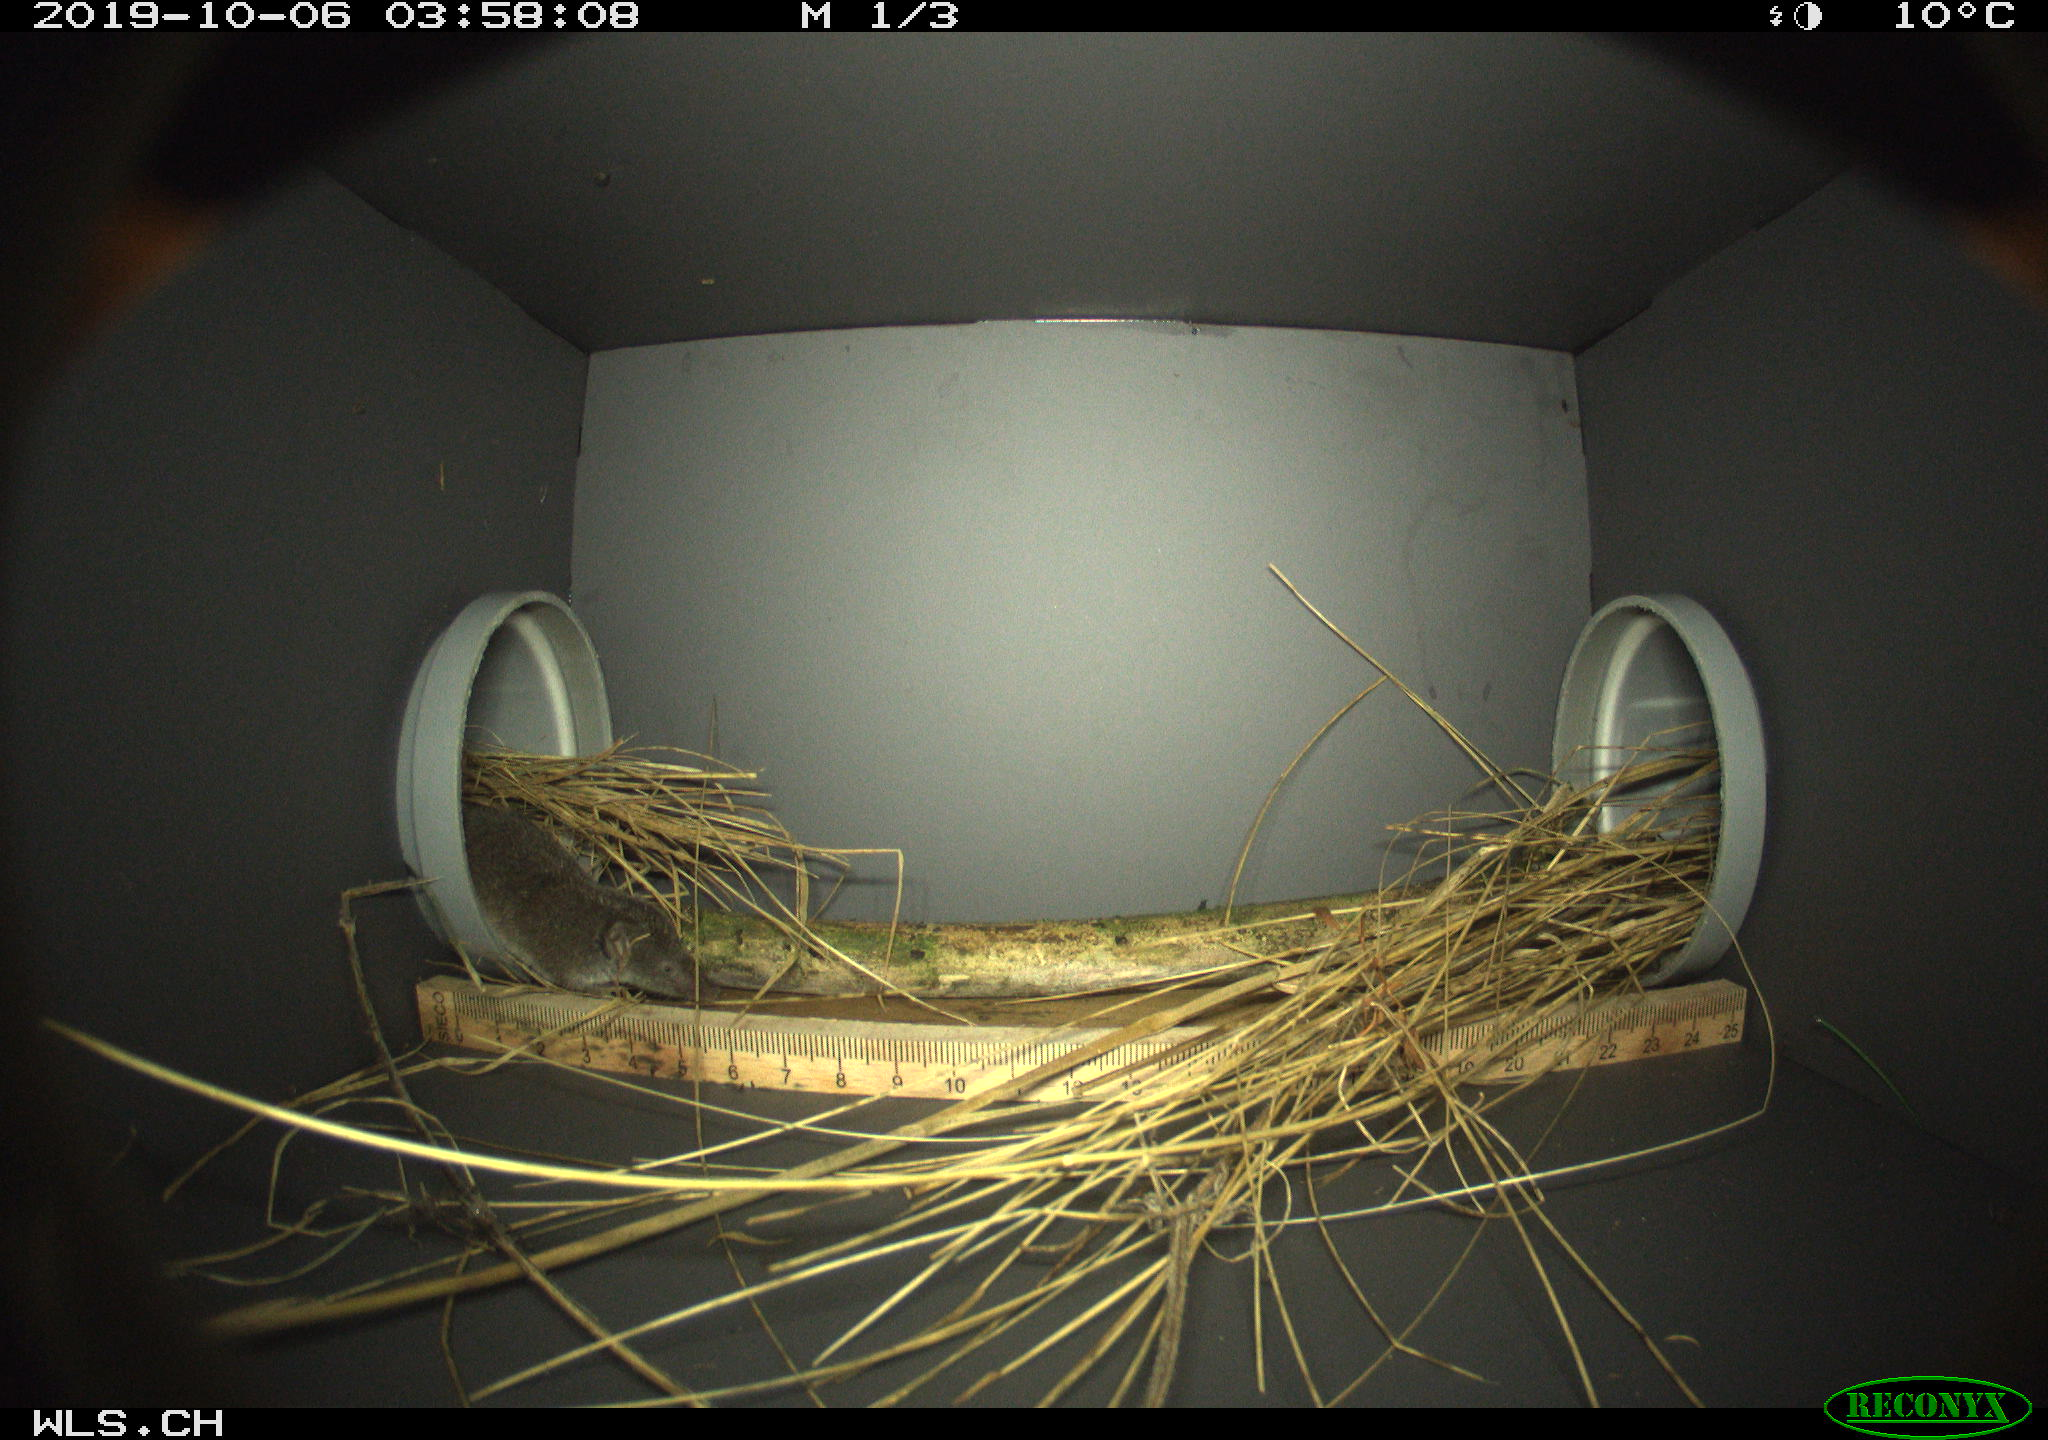

In [10]:
image_path = '/cfs/earth/scratch/kraftjul/BA/data/dataset/sessions/session_01/H_1/RCNX0001.JPG'

image = Image.open(image_path)
image.show()

Randomly selected index: 431004


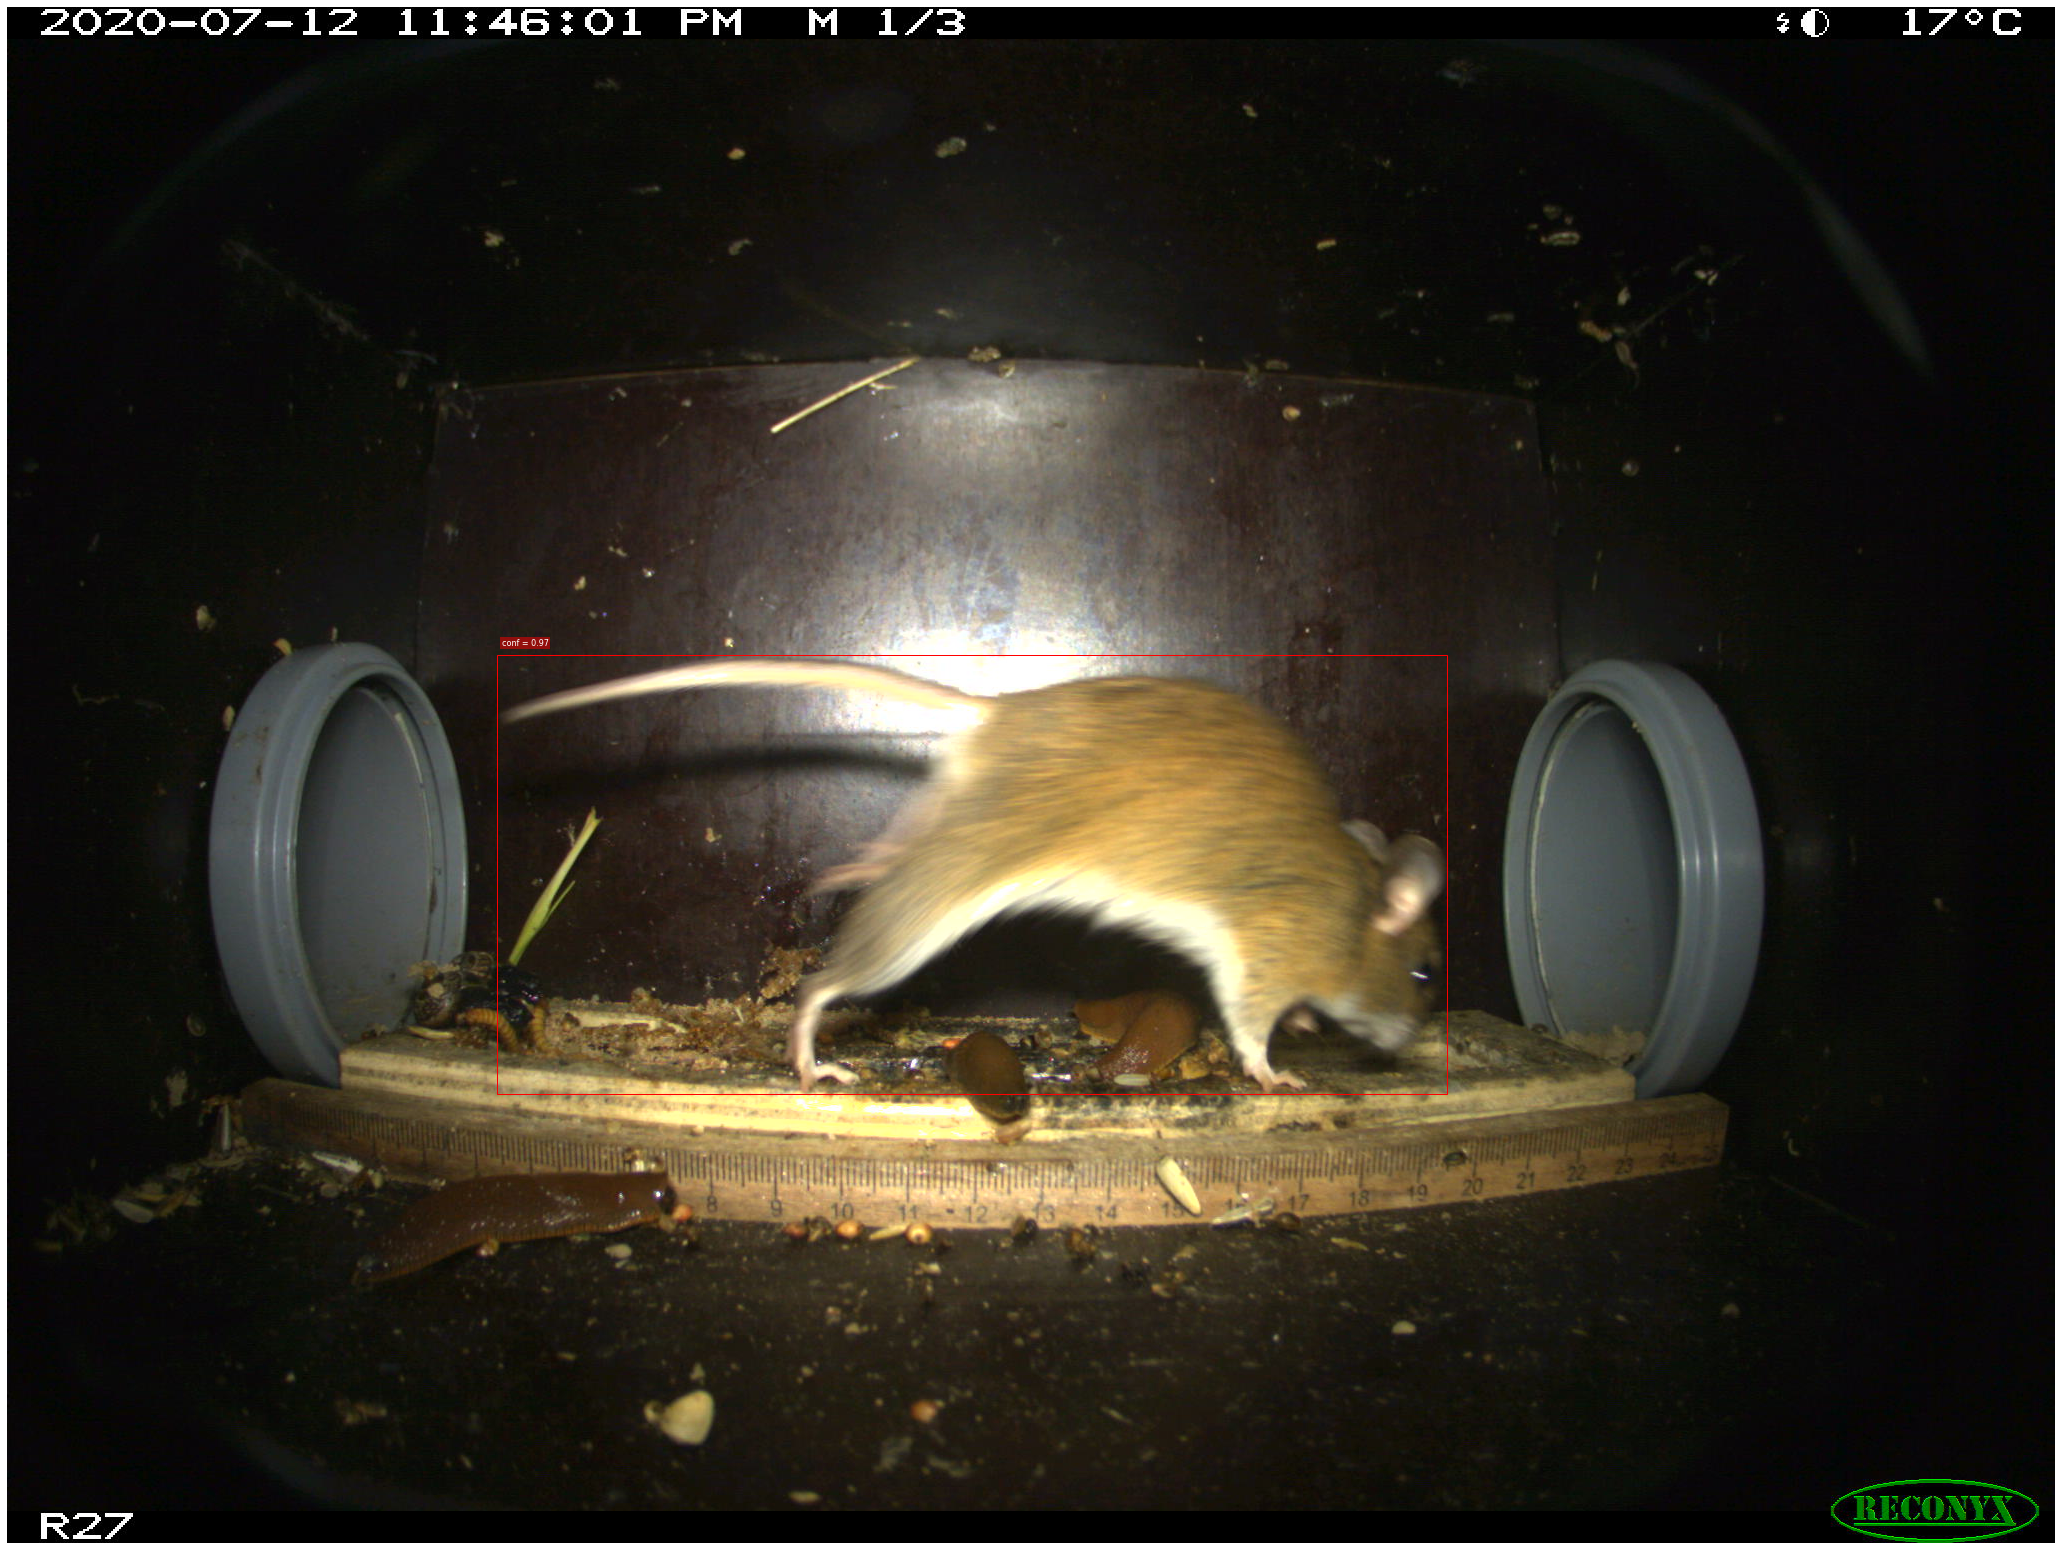

In [15]:
i = randint(0, len(dataset_img) - 1)
print(f"Randomly selected index: {i}")
sample = dataset_img[i]

fig = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
display(fig)

In [12]:
108812

108812

In [13]:
from IPython.display import display


In [14]:
# lowest_conf_indices = dataset_img.ds.nsmallest(5, 'conf').index.tolist()

# for i in lowest_conf_indices:
#     sample = dataset_img[i]
#     figure = plot_image_with_bbox(image=sample['x'], bbox=sample['bbox'], conf=sample['conf'])
#     display(figure)
    